# Neural Networks

This notebook implements a simple neural network for multi-class classification.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
from sklearn.datasets import fetch_openml

In [17]:
data, targets = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

# Normalization vs. Standardization

Scaling features in general is useful for many machine learning algorithms since most of them are not scale-invariant.

Normalization bounds the features to a fixed interval. This is typically done to scale features to $[0, 1]$.
Standardization centers the features with mean 0 and standard deviation 1. This results in features that have the same parameters as a standard normal distribution.

Standardization is well suited for optimization algorithms such as gradient descent where the weights are typically randomly generated with small values centered around 0. Additionally, outliers are well preserved with standardization as opposed to normalization.

In [18]:
# Split the data
X_train = data[:60000]
y_train = targets[:60000]
X_test = data[60000:]
y_test = targets[60000:]

# Normalization
# X_train = X_train / 255.
# X_test = X_test / 255.

# Standardization
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std() # Is this correct?

In [19]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])


def sigmoid(x):
    return 1. / (1. + np.exp(-x))


def sigmoid_grad(out, grad_in):
    return out * (1 - out) * grad_in


def softmax(x):
    num = np.exp(x - np.max(x))
    
    return num / np.sum(num, axis=0, keepdims=True)


def mse(x, y):
    return np.mean((x - y)**2)


def mse_grade(x, y):
    return x - y


# def softmax_grad(out, grad_in):
#       return (np.einsum('ij,jk->ijk', out, np.eye(out.shape[-1])) \
#            - np.einsum('ij,ik->ijk', out, out))
    
    
def softmax_grad(probs, bp_err):
    dim = probs.shape[1]
    output = np.empty(probs.shape)
    for j in range(dim):
        d_prob_over_xj = - (probs * probs[:,[j]])  # i.e. prob_k * prob_j, no matter k==j or not
        d_prob_over_xj[:,j] += probs[:,j]   # i.e. when k==j, +prob_j
        output[:,j] = np.sum(bp_err * d_prob_over_xj, axis=1)
    return output


def cross_entropy_loss(pred, target):
    return -target * np.log(pred)


def cross_entropy_grad(pred, target):
    return target - pred

In [20]:
num_features = X_train.shape[1]
num_classes = 10

# Output layer configuration
rs = RandomState(MT19937(SeedSequence(42))) # for consistency
layer1_weights = (rs.rand(num_classes, num_features + 1) - 0.5)

In [21]:
# Get the first sample with shape (1, 784)
sample = X_test[0].reshape(1, -1)

# Forward pass
layer1_a = layer1_weights @ np.concatenate((np.ones((sample.shape[0], 1)), sample), axis=1).T
layer1_z = softmax(layer1_a)
loss = cross_entropy_loss(layer1_z.T, get_one_hot(y_test.astype(int)[0].reshape(1, -1), num_classes))
print(np.mean(loss, axis=0))

# Backward pass
d_loss = cross_entropy_grad(layer1_z.T, get_one_hot(y_test.astype(int)[0].reshape(1, -1), num_classes))
d_layer1_weights = d_loss.T @ np.concatenate((np.ones((sample.shape[0], 1)), sample), axis=1)
d_layer1_weights = d_layer1_weights.squeeze(1)
print(d_layer1_weights.shape)

# Update weights
layer1_weights += 0.01 * d_layer1_weights
print(layer1_weights)

[[0.         0.         0.         0.         0.         0.
  0.         2.77577083 0.         0.        ]]
(10, 785)
[[ 0.04169459  0.11979496 -0.44250247 ...  0.41991642 -0.14600867
  -0.34059742]
 [ 0.43695774 -0.33309442  0.27054984 ... -0.23493974  0.34570327
  -0.4857454 ]
 [-0.32432122 -0.21547196 -0.11539488 ... -0.05236539  0.48477743
  -0.12416918]
 ...
 [-0.34850662  0.32173753 -0.41777342 ... -0.05714398 -0.13227595
  -0.19807041]
 [ 0.3149436   0.35988408  0.04094178 ... -0.44148146 -0.37092686
  -0.18820815]
 [ 0.47064705  0.17588679  0.13516627 ...  0.02566926 -0.45518632
   0.0804155 ]]


# Batch Training

The cell below performs batch training over an entire epoch of 60k samples.

Training Accuracy: 86.21%
Testing Accuracy: 87.62%


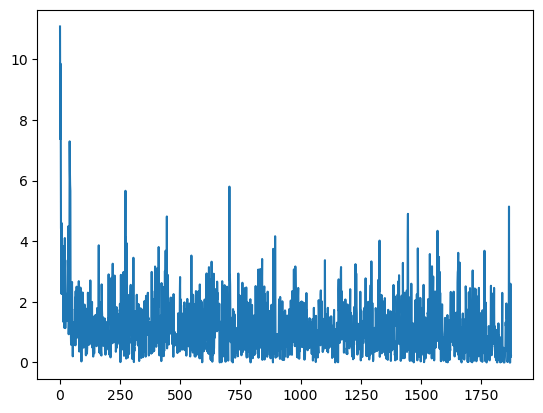

In [22]:
def train(X, y):
    # Initialize weights
    rs = RandomState(MT19937(SeedSequence(42))) # for consistency
    layer1_weights = (rs.rand(num_classes, num_features + 1) - 0.5)

    losses = []
    batch_size = 32
    correct = 0
    lr = 0.01

    for batch_idx in range(0, X.shape[0], batch_size):
        start_idx = batch_idx
        end_idx = start_idx + batch_size if start_idx + batch_size < X.shape[0] else X.shape[0]
        batch_samples = X[start_idx : end_idx]
        batch_targets = get_one_hot(y[start_idx : end_idx].astype(int), 10)

        # Forward Pass
        layer1_a = layer1_weights @ np.concatenate((np.ones((batch_samples.shape[0], 1)), batch_samples), axis=1).T
        layer1_z = softmax(layer1_a)

        # print(layer1_a, layer1_z)

        loss = cross_entropy_loss(layer1_z.T, batch_targets)

        # print(loss)
        loss = np.sum(np.mean(loss, axis=0))
        losses.append(loss)

        # Update the number of correct training predictions
        correct += np.sum(np.argmax(layer1_z, axis=0) == y[start_idx : end_idx].astype(int))

        # Backward Pass
        d_loss = cross_entropy_grad(layer1_z.T, batch_targets)
        # print(d_loss)
        # d_layer1_z = softmax_grad(layer1_z.T, d_loss) # Not necessary! `cross_entropy_grad` includes the softmax derivative.
        d_layer1_weights = d_loss.T @ np.concatenate((np.ones((batch_samples.shape[0], 1)), batch_samples), axis=1)
        # print(d_layer1_weights)

        # Gradient step
        layer1_weights = layer1_weights + lr * d_layer1_weights

    return correct, losses, layer1_weights

def test(X, y, weights):
    batch_size = 32
    correct = 0

    for batch_idx in range(0, X.shape[0], batch_size):
        start_idx = batch_idx
        end_idx = start_idx + batch_size if start_idx + batch_size < X.shape[0] else X.shape[0]
        batch_samples = X[start_idx : end_idx]

        # Forward Pass
        layer1_a = weights @ np.concatenate((np.ones((batch_samples.shape[0], 1)), batch_samples), axis=1).T
        layer1_z = softmax(layer1_a)

        # Update the number of correct training predictions
        correct += np.sum(np.argmax(layer1_z, axis=0) == y[start_idx : end_idx].astype(int))

    return correct

train_correct, losses, weights = train(X_train, y_train)
test_correct = test(X_test, y_test, weights)

print(f'Training Accuracy: {train_correct / X_train.shape[0] * 100:.2f}%')
print(f'Testing Accuracy: {test_correct / X_test.shape[0] * 100:.2f}%')

# Plot loss curve
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(losses)
